In [3]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn import datasets
from strat_earnings import *
import pandas_ta as ta

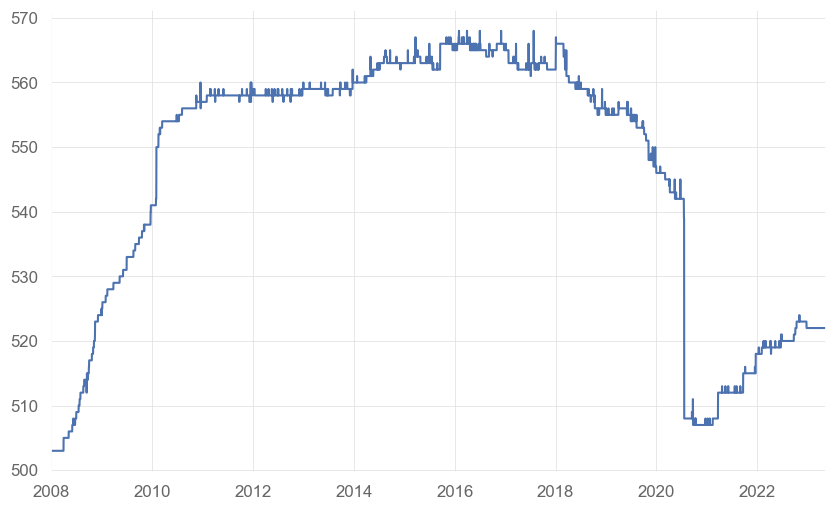

In [4]:

universe = master.baskets.get_index_historical_components('GSPC')
P = func.presence_matrix(universe).loc['2008':]
P.sum(1).plot()
market_data = pd.read_parquet('data/US/mkt_data.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()

In [5]:
earnings = import_earnings()
balance_sheet = import_balance_sheets()
cash_flow = import_cash_flows()
income_statement = import_income_statements()

## Financial ratios :

- Net Debt / cash
- Debt-to-Equity Ratio: Total Debt / Total Equity
- Return on Equity (ROE): Net Income / Total Equity
- Return on Assets (ROA): Net Income / Total Assets
- Gross Profit Margin: (Total Revenue - Cost of Goods Sold) / Total Revenue
- Operating Profit Margin: Operating Income / Total Revenue
- Net Profit Margin: Net Income / Total Revenue
- Current Ratio: Current Assets / Current Liabilities
- Quick Ratio: (Current Assets - Inventory) / Current Liabilities
- Accounts Receivable Turnover: Total Revenue / Average Accounts Receivable
- Inventory Turnover: Cost of Goods Sold / Average Inventory
- Asset Turnover Ratio: Total Revenue / Total Assets
- Price-to-Earnings Ratio (P/E Ratio): Price per Share / Earnings per Share
- Dividend Yield: Annual Dividend per Share / Price per Share
- Price-to-Book Ratio (P/B Ratio): Price per Share / Book Value per Share
- Return on Investment (ROI): (Net Income + Interest Expense) / Total Assets
- Price/Earnings to Growth (PEG) Ratio: P/E Ratio / Annual Earnings per Share Growth Rate
- Price/Sales (P/S) Ratio: Market Capitalization / Total Revenue
- EBITDA Margin: EBITDA / Total Revenue
- EBITDA Coverage Ratio: EBITDA / Interest Expense
- Free Cash Flow (FCF) Yield: FCF per Share / Stock Price
- Return on Invested Capital (ROIC): EBIT / (Total Equity + Total Debt - Cash and Equivalents)
- Earnings Before Interest, Taxes, Depreciation, and Amortization per Share (EBITDA/Share): EBITDA / Shares Outstanding
- Price-to-Operating Cash Flow Ratio: Price per Share / Operating Cash Flow per Share
- Earnings Yield: Earnings per Share / Price per Share
- Debt-to-EBITDA Ratio: Total Debt / EBITDA


In [5]:
net_debt = balance_sheet['netDebt'].unstack().reindex_like(P).ffill().astype(float)
cash = balance_sheet['cash'].unstack().reindex_like(P).ffill().astype(float)
debt_cash = (net_debt/ cash).stack()

In [6]:
total_debt =balance_sheet['shortLongTermDebtTotal'].unstack().reindex_like(P).ffill().astype(float)
total_equity = balance_sheet['commonStockTotalEquity'].unstack().reindex_like(P).ffill().astype(float)
debt_equity = (total_debt/total_equity).stack()

In [7]:
net_income = income_statement['netIncome'].unstack().reindex_like(P).ffill().astype(float)
total_assets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
roa = (net_income/total_assets).stack()


In [8]:
roe =  (net_income/ total_equity).stack()

In [9]:
total_revenue = income_statement['totalRevenue'].unstack().reindex_like(P).ffill().astype(float)
cost_revenue = income_statement['costOfRevenue'].unstack().reindex_like(P).ffill().astype(float)
gross_margin = ((total_revenue - cost_revenue)/ total_revenue).stack()


In [10]:
total_revenue = income_statement['totalRevenue'].unstack().reindex_like(P).ffill().astype(float)
cost_revenue = income_statement['costOfRevenue'].unstack().reindex_like(P).ffill().astype(float)

operating_profit = income_statement['operatingIncome'].unstack().reindex_like(P).ffill().astype(float)
operating_margin = (operating_profit / total_revenue).stack()

In [11]:
current_assets = balance_sheet['totalCurrentAssets'].unstack().reindex_like(P).ffill().astype(float)
current_liab = balance_sheet['totalCurrentLiabilities'].unstack().reindex_like(P).ffill().astype(float)
current_ratio = (current_assets/ current_liab).stack()

In [12]:
inventory = balance_sheet['inventory'].unstack().reindex_like(P).ffill().astype(float)
quick_ratio = ((current_assets - inventory)/ current_liab).stack()

In [13]:
asset_turnover_ratio = (total_assets/ total_revenue).stack()

In [14]:
price = market_data['close'].unstack().reindex_like(P).ffill().astype(float)
eps =  earnings['epsActual'].unstack().reindex_like(P).ffill().astype(float)
pe_ratio = (price/eps).stack()

In [15]:
mkt_cap = market_data['MktCap'].unstack().reindex_like(P).ffill().astype(float)
ps_ratio = (mkt_cap/total_revenue).stack()

In [16]:
earnings_yield = (eps/price).stack()

In [6]:
ebitda = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)
total_debt =balance_sheet['shortLongTermDebtTotal'].unstack().reindex_like(P).ffill().astype(float)
debt_to_ebitda = (total_debt/ebitda).stack()

In [18]:
shares = balance_sheet['commonStockSharesOutstanding'].unstack().reindex_like(P).ffill().astype(float)
ebitda_share = (ebitda/shares).stack()

In [19]:
ebit = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
totalCurrentAssets = balance_sheet['totalCurrentAssets'].unstack().reindex_like(P).ffill().astype(float)
roic = (ebit/(totalAssets - totalCurrentAssets)).stack()


In [20]:
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
totalLiabilities = balance_sheet['totalLiab'].unstack().reindex_like(P).ffill().astype(float)
book_value = totalAssets - totalLiabilities
shares = balance_sheet['commonStockSharesOutstanding'].unstack().reindex_like(P).ffill().astype(float)
book_value_share = book_value/ shares
close = market_data['close'].unstack().reindex_like(P).astype(float)
pb_ratio = (close/book_value_share).stack()

In [21]:
eps_actual = earnings['epsActual'].unstack().reindex_like(P).ffill().astype(float)
eps_estimate = earnings['epsEstimate'].unstack().reindex_like(P).ffill().astype(float)
eps_surprise = (eps_actual - eps_estimate).stack()

In [22]:
ratios = {
        'eps_surprise':eps_surprise,
        'pb_ratio':pb_ratio,
        'roic': roic,
        'ebitda_share':ebitda_share,
        'debt_to_ebitda': debt_to_ebitda,
        'earnings_yield': earnings_yield,
        'ps_ratio':ps_ratio,
        'pe_ratio':pe_ratio,
        'asset_turnover_ratio':asset_turnover_ratio,
        'quick_ratio':quick_ratio,
        'current_ratio':current_ratio,
        'operating_margin':operating_margin,
        'gross_margin':gross_margin,
        'roe':roe,
        'roa':roa,
        'debt_equity':debt_equity,
        'debt_cash':debt_cash

        }

In [22]:
dates_earnings = DATES_EARNINGS(earnings,0.02,0.98,10,10)
dates_earnings_all = dates_earnings['dates_earn_cumul'].iloc[-1]
ebitda = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)
total_debt =balance_sheet['shortLongTermDebtTotal'].unstack().reindex_like(P).ffill().astype(float)
debt_to_ebitda = (total_debt/ebitda).stack()

In [27]:
data = debt_to_ebitda.unstack()
data = data[data.index.isin(dates_earnings_all)]
data = data[P].rank(axis=1,pct=True,ascending=True)
data = data.rolling(500,min_periods=100).rank(pct=True,ascending=True).apply(norm.ppf)


In [28]:
import pandas_ta as ta
from tqdm import tqdm
results ={}
for ticker in tqdm(data.columns.tolist()):
    df_ticker = data[ticker]
    try :
        metrics = ta.kurtosis(data[ticker],length=50).fillna(0)
        results[ticker] = metrics

    except :
        print(ticker)
metrics = pd.concat(results,axis=1).reindex_like(P)

  0%|          | 0/674 [00:00<?, ?it/s]c:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
100%|██████████| 674/674 [00:00<00:00, 1545.02it/s]


C:\Users\marti\AppData\Local\Temp\ipykernel_13112\2739122725.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(20,min_periods=5).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
C:\Users\marti\AppData\Local\Temp\ipykernel_13112\2739122725.py:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicind'],axis=1).apply(center)


Sharpe      2.4
Turnover    0.2
biais       2.0
dtype: float64

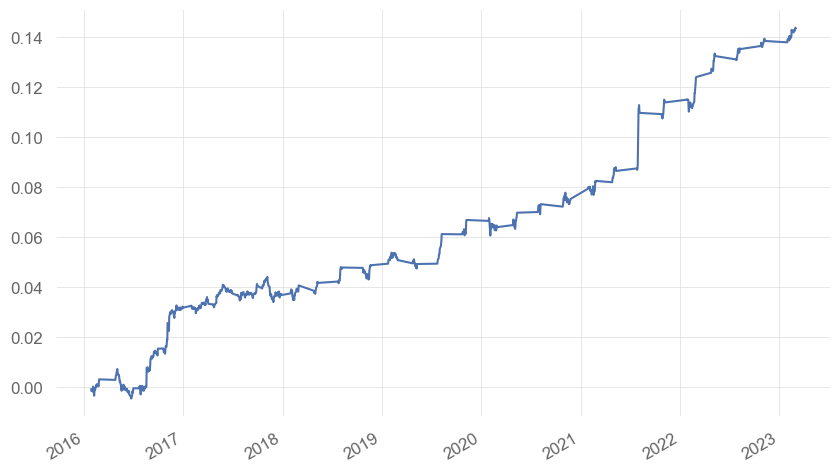

In [29]:
signal = metrics[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal = signal[P].rolling(20,min_periods=5).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal = signal.reindex_like(P)
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)

signal[signal.abs()<0.5] = None

signal = signal[P].groupby(GICS['gicind'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1).replace({0:np.nan}).dropna().loc['2016':]
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':PNL.mean()*1e4}).round(1)

<Axes: >

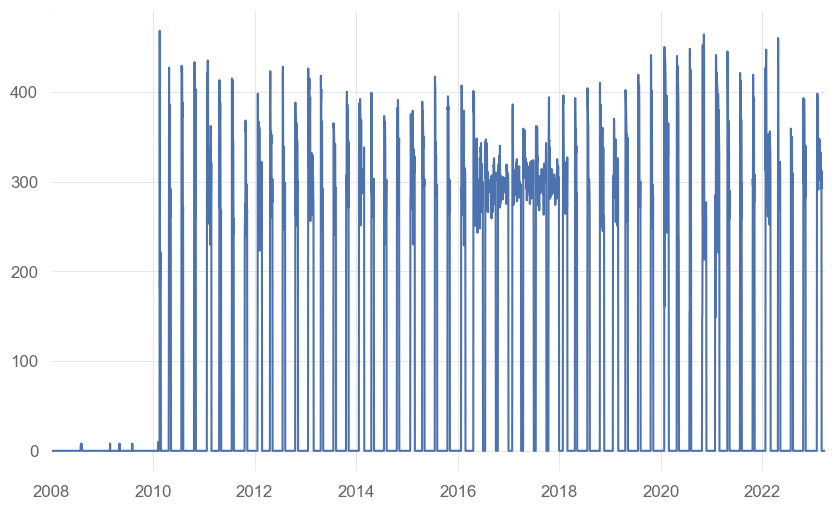

In [35]:
signal.count(1).plot()

In [7]:

P = pd.read_parquet('data/US/universe_table.pq')
earnings = import_earnings()
balance_sheet = import_balance_sheets()
income_statement = import_income_statements()
ebitda = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)
total_debt =balance_sheet['shortLongTermDebtTotal'].unstack().reindex_like(P).ffill().astype(float)
debt_to_ebitda = (total_debt/ebitda)[P]
debt_to_ebitda = debt_to_ebitda[P].rank(axis=1,pct=True,ascending=True)
debt_to_ebitda = debt_to_ebitda.rolling(500,min_periods=10).rank(pct=True,ascending=True).apply(norm.ppf)
dates_earnings = DATES_EARNINGS(earnings,0.02,0.98,10,10)
simulations_earnings = dates_earnings.loc['2015Q4':'2023Q1'].index
size = len(simulations_earnings)
tuples = [(simulations_earnings,dates_earnings,j,debt_to_ebitda,P) for j in range(1,size)]

In [9]:
predict_earnings(*tuples[-1])

2023Q1 2022Q4


c:\Users\marti\Documents\research perso\strat_earnings.py:47: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  sub_df = debt_cash[debt_cash.index.isin(dates_train+dates)].dropna(0,'all')
c:\Users\marti\Documents\research perso\strat_earnings.py:47: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  sub_df = debt_cash[debt_cash.index.isin(dates_train+dates)].dropna(0,'all')
c:\Users\marti\Documents\research perso\strat_earnings.py:47: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  sub_df = debt_cash[debt_cash.index.isin(dates_train+dates)].dropna(0,'all')
c:\Users\marti\Documents\research perso\strat_earnings.py:47: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  sub_df = debt_cash[debt_cash.index.isin(dates_train+dates)].dropna(0,'all')
c:\Users\marti\Documents\research pe

In [333]:
result_df = pd.DataFrame()

# Iterate through the dictionary and add each DataFrame as a new column
for key, df in ratios.items():
    print(key)
    df = pd.DataFrame({key:df})
    df.index.names = ['Date','Ticker']

    # Unstack the MultiIndex to create columns for each level
    # Append the DataFrame to the result DataFrame
    ratios[key] = df

# Print the result DataFrame
print(result_df)

eps_surprise


ValueError: If using all scalar values, you must pass an index

In [24]:
data_raw = pd.DataFrame( {'close':market_data['close'].unstack().reindex_like(P).stack()})
features = list(ratios)
for col in tqdm(features):
    data_raw[col] = ratios[col]

data_raw

100%|██████████| 17/17 [00:26<00:00,  1.58s/it]


close  eps_surprise   pb_ratio      roic  ebitda_share  \
           Ticker                                                              
2008-01-01 ZMH     331.0000           NaN        NaN       NaN           NaN   
2008-01-02 A        36.2888           NaN        NaN       NaN           NaN   
           AA       36.1300           NaN        NaN       NaN           NaN   
           AAL      13.3200           NaN        NaN       NaN           NaN   
           AAP      37.5900           NaN        NaN       NaN           NaN   
...                     ...           ...        ...       ...           ...   
2023-04-05 YUM     131.9400          0.05  -4.266199  0.143026      2.111498   
           ZBH     128.5900          0.05   2.243135  0.011798      0.935653   
           ZBRA    300.1500          0.16   5.919800  0.043571      4.563802   
           ZION     28.6300          0.20   0.870831  0.006057      3.393156   
           ZTS     167.6500          0.10  17.910526  0.104327      1.645461   

                   debt_to_ebitda  earnings_yield   ps_ratio    pe_ratio  \
           Ticker                                                          
2008-01-01 ZMH                NaN             NaN        NaN         NaN   
2008-01-02 A                  NaN             NaN        NaN         NaN   
           AA                 NaN             NaN        NaN         NaN   
           AAL                NaN             NaN        NaN         NaN   
           AAP                NaN             NaN        NaN         NaN   
...                           ...             ...        ...         ...   
2023-04-05 YUM          19.556106        0.009929  18.837246  100.717557   
           ZBH          29.019358        0.014620  14.739782   68.398936   
           ZBRA          8.788618        0.015825  10.713008   63.189474   
           ZION          3.790099        0.064268   4.754566   15.559783   
           ZTS           8.708010        0.006860  38.417910  145.782609   

                   asset_turnover_ratio  quick_ratio  current_ratio  \
           Ticker                                                     
2008-01-01 ZMH                      NaN          NaN            NaN   
2008-01-02 A                        NaN          NaN            NaN   
           AA                       NaN          NaN            NaN   
           AAL                      NaN          NaN            NaN   
           AAP                      NaN          NaN            NaN   
...                                 ...          ...            ...   
2023-04-05 YUM                 2.895493     0.958559       0.966366   
           ZBH                11.542381     4.189050       8.133933   
           ZBRA                5.009315     0.438679       0.807461   
           ZION              102.571592     4.882027       4.884402   
           ZTS                 7.316176     1.629618       2.370066   

                   operating_margin  gross_margin         roe       roa  \
           Ticker                                                         
2008-01-01 ZMH                  NaN           NaN         NaN       NaN   
2008-01-02 A                    NaN           NaN         NaN       NaN   
           AA                   NaN           NaN         NaN       NaN   
           AAL                  NaN           NaN         NaN       NaN   
           AAP                  NaN           NaN         NaN       NaN   
...                             ...           ...         ...       ...   
2023-04-05 YUM             0.283804      0.468053   16.130435  0.063462   
           ZBH            -0.015506      0.714920  -42.000000 -0.006181   
           ZBRA            0.172987      0.455755  186.000000  0.024704   
           ZION            0.411226      1.058419    0.110721  0.003172   
           ZTS             0.411765      0.679902   92.200000  0.030888   

                   debt_equity  debt_cash  
           Ticker                          
2008

In [ ]:
data_scale = data_raw.copy()
for column in tqdm(features) :
    sub_df = data_raw[column].unstack().reindex_like(P).ffill()
    sub_df_rank_cs = sub_df[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).round(2)
    sub_df_rank_cs = sub_df_rank_cs.fillna(sub_df_rank_cs.mean(1))[P]
    data_scale[column+'_cs'] = sub_df_rank_cs.stack()
    sub_df_rank_ts = sub_df_rank_cs.rolling(252,min_periods=10).rank(pct=True,ascending=True).clip(0.01,0.99).round(2)
    sub_df_rank_ts = sub_df_rank_ts.fillna(sub_df_rank_ts.mean(1))[P]
    data_scale[column+'_ts'] = sub_df_rank_ts.stack()
    data_scale.drop(column,axis=1,inplace=True)
data_model = data_scale.dropna()



In [ ]:
# data_model.to_parquet('data_model.pq')
data_model = pd.read_parquet('data/US/data_model.pq')
# data_model['close']= R[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf).round(2).stack()
data_model['close'] = market_data['close']
data_model = data_model.dropna()

In [ ]:
Y = data_model.iloc[:,0]
X= data_model.iloc[:,1:]
X_train = X.loc[:'2018']
Y_train = Y.loc[:'2018']
X_test = X.loc['2018':]
Y_test = Y.loc['2018':]
Y_test

In [ ]:
dates_test = pd.to_datetime(X.loc['2022':].index.get_level_values(0)).unique()
results = {}
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
result = pd.DataFrame().reindex_like(P)
for i,date in (enumerate(tqdm(dates_test[1:-1]))):
    curr_date = str(date.date())
    next_date = str(dates_test[i+1].date())
    X_train = X.loc[:curr_date]
    Y_train = Y.loc[:curr_date]
    tickers = X_train.loc[curr_date].index.tolist()
    for ticker in tickers:
        try :
            x_train = X_train.xs(ticker,level=1)
            y_train = Y_train.xs(ticker,level=1)
            neigh = KNeighborsRegressor(n_neighbors=10).fit(x_train,y_train)
            pred = neigh.predict(pd.DataFrame(X_train.loc[(curr_date,ticker)]).T)[0]
        except :
            pred = np.nan
        result.loc[next_date,ticker] = pred

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(df['true'],df['pred'])

In [ ]:
for ticker in result.columns.tolist():
    df = pd.DataFrame({'true':close[ticker],'pred':result[ticker]}).dropna()
    df.plot(title=ticker+'   '+ str(r2_score(df['true'],df['pred'])))
    plt.show()


In [ ]:
df.corr()

In [ ]:
str(curr_date.date())

In [ ]:
result = pd.DataFrame().reindex_like(P)
for i,date in (enumerate(tqdm(dates_test[1:-1]))):
    curr_date = date
    previous_date = dates_test[i-1]
    next_date = dates_test[i+1]
    X_train = X.loc[:previous_date]
    Y_train = Y.loc[:previous_date]
    tickers = X_train.loc[previous_date].index.tolist()
    for ticker in tickers:
        x_train = X_train.xs(ticker,level=1)
        y_train = Y_train.xs(ticker,level=1)
        neigh = KNeighborsRegressor(n_neighbors=5).fit(x_train,y_train)
        pred = neigh.predict(pd.DataFrame(X.loc[(curr_date,ticker)]).T)[0]

        result.loc[curr_date,ticker] = pred


In [ ]:
tickers = X_train.loc[previous_date].index.tolist()
for ticker in tickers:
    x_train = X_train.xs(ticker,level=1)
    y_train = Y_train.xs(ticker,level=1)
    neigh = KNeighborsRegressor(n_neighbors=5).fit(x_train,y_train)
    pred = neigh.predict(pd.DataFrame(X.loc[(curr_date,ticker)]).T)[0]

    result.loc[curr_date,ticker] = pred


In [ ]:
neigh = KNeighborsRegressor(n_neighbors=5).fit(x_train,y_train)
pred = neigh.predict(X.loc[curr_date].loc(ticker))

In [ ]:
pred = neigh.predict(pd.DataFrame(X.loc[(curr_date,ticker)]).T)[0]
true = Y.loc[(next_date,ticker)]
pred

In [ ]:
signal = pd.DataFrame(results).T.reindex_like(P)[P].dropna(0,'all')
signal = signal[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.5] = None
signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal.abs().sum(1),0)

pnl = (signal[P].shift()*R).dropna(0,'all').sum(1)
sr = sharpe(pnl)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
pnl.cumsum().plot()
plt.ylabel('pnl')
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':pnl.mean()*1e4}).round(1)

In [ ]:
0.04*(253/34)*3